In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import cv2
from tensorflow.keras.utils import to_categorical
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.optimizers import Adam,SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
os.listdir("../Dataset/Data")

Using TensorFlow backend.


['best_model_todate.h5',
 'best_model_todate.index',
 'checkpoint',
 'chest_xray',
 'MNIST',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'xray',
 'xray2']

In [2]:
len(os.listdir("../Dataset/Data/chest_xray/train/PNEUMONIA"))

3883

The dataset is divided into three sets: 1) Train set 2) Validation set and 3) Test set.

# Data Visualization


Train set:
PNEUMONIA=3883
NORMAL=1349
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


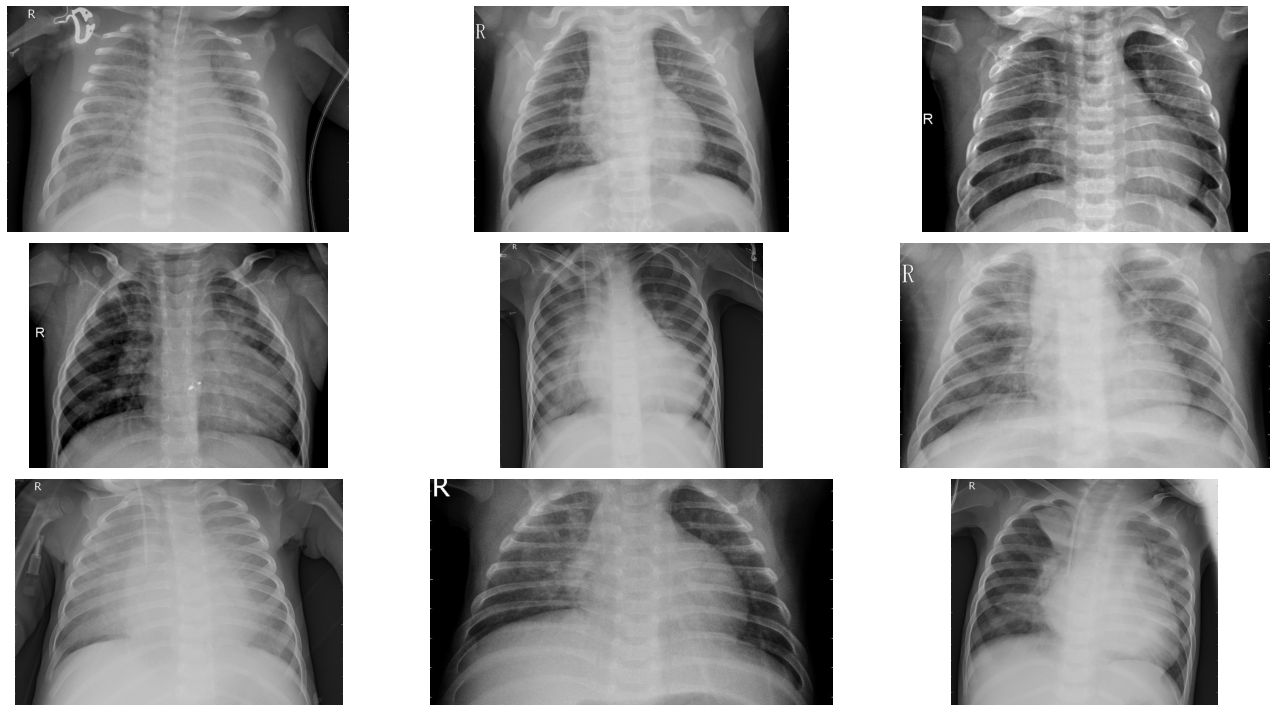

In [3]:
train_dir = "../Dataset/Data/chest_xray/train"
test_dir = "../Dataset/Data/chest_xray/test"
val_dir = "../Dataset/Data/chest_xray/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("../Dataset/Data/chest_xray/train/PNEUMONIA")
pneumonia_dir = "../Dataset/Data/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

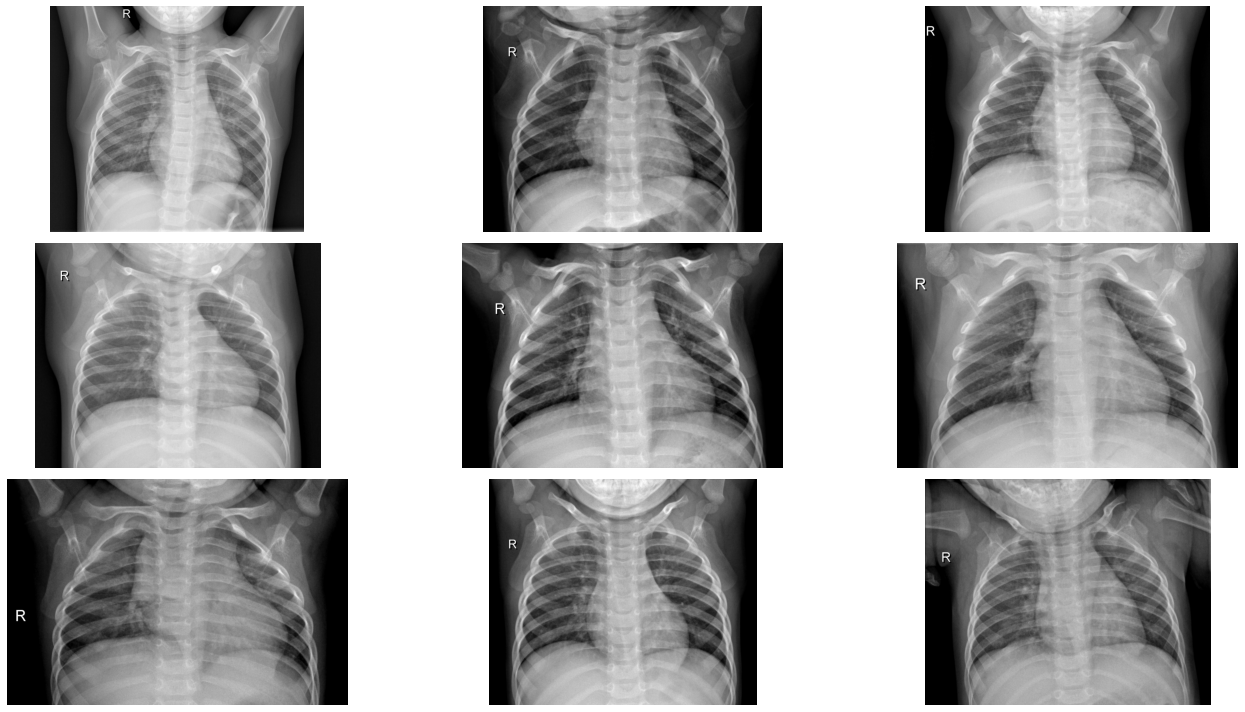

In [4]:
normal = os.listdir("../Dataset/Data/chest_xray/train/NORMAL")
normal_dir = "../Dataset/Data/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

The dimensions of the image are 1858 pixels width and 2090 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 128.9075 and the standard deviation is 62.3010


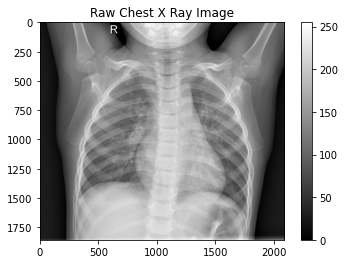

In [5]:
normal_img = os.listdir("../Dataset/Data/chest_xray/train/NORMAL")[0]
normal_dir = "../Dataset/Data/chest_xray/train/NORMAL"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# Ivestigate pixel value distribution

C:\Users\mohammed\Anaconda3\envs\Tensor-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

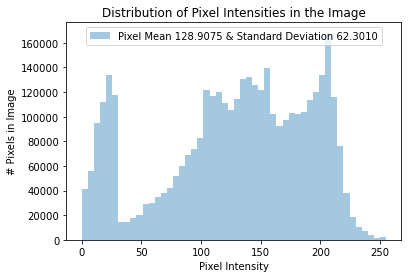

In [6]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [6]:
# Define path to the data directory
data_dir = Path('../Dataset/Data/chest_xray/')

# Path to train directory (Fancy pathlib...no more os.path!!)
#train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

# 2. Image Preprocessing
Before training, we'll first modify your images to be better suited for training a convolutional neural network. For this task we'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation.

This class also provides support for basic data augmentation such as random horizontal flipping of images.
We also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will faciliate model training by standardizing the input distribution).
The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (we will want this because the pre-trained model that we'll use requires three-channel inputs).

In [7]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
     horizontal_flip = True,
    width_shift_range=0.1,
    #shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [8]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


# Build a separate generator fo valid and test sets

Now we need to build a new generator for validation and t esting data.

Why can't use the same generator as for the training data?

Look back at the generator we wrote for the training data.

It normalizes each image per batch, meaning thatit uses batch statistics.
We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time).
Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data).
What we need to do is to normalize incomming test data using the statistics computed from the training set.

In [9]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=16, 
                                            shuffle=True, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=True, 
                                                class_mode='categorical',
                                                target_size=(224, 224))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='categorical',
                                            target_size=(224, 224))

Found 5232 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 3.6040 and the minimum is -3.4810
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


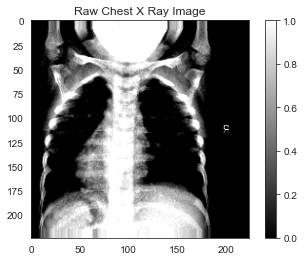

In [12]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

C:\Users\mohammed\Anaconda3\envs\Tensor-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

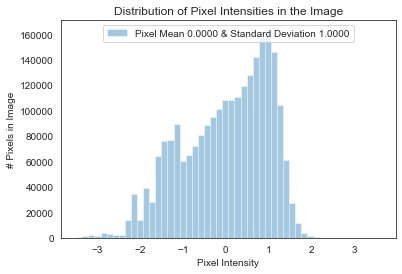

In [13]:
sns.distplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

# Building a CNN model

## Impact of imbalance data on loss function

Loss Function:
$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

We can rewrite the the overall average cross-entropy loss over the entire training set `D` of size `N` as follows:
$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$



When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [10]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: 1.84, 1: 0.69}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 178, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 176, 176, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 86, 86, 64)        2

In [14]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 24s 235ms/step - loss: 1.7180 - accuracy: 0.7850 - val_loss: 42.1750 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 22s 224ms/step - loss: 0.5486 - accuracy: 0.8363 - val_loss: 58.1073 - val_accuracy: 0.5000
Epoch 3/10
100/100 [==============================] - 20s 198ms/step - loss: 0.3902 - accuracy: 0.8462 - val_loss: 68.4305 - val_accuracy: 0.5000
Epoch 4/10
100/100 [==============================] - 21s 211ms/step - loss: 0.1358 - accuracy: 0.8900 - val_loss: 13.4760 - val_accuracy: 0.5000
Epoch 5/10
100/100 [==============================] - 21s 206ms/step - loss: 0.1843 - accuracy: 0.8612 - val_loss: 0.6787 - val_accuracy: 0.6875
Epoch 6/10
100/100 [==============================] - 19s 190ms/step - loss: 0.1162 - accuracy: 0.8900 - val_loss: 1.4208 - val_accuracy: 0.5625
Epoch 7/10
100/100 [==============================] - 18s 181ms/step - loss: 0.1090 - accuracy: 0.8825 - val_loss: 1.6105 - va

Text(0.5, 1.0, 'Accuracy Evolution')

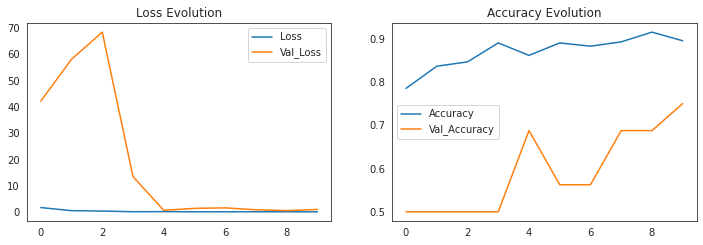

In [15]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [16]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 16s 26ms/step - loss: 0.4056 - accuracy: 0.8365
Test Accuracy: 83.65%
652/652 [==============================] - 113s 174ms/step - loss: 0.3156 - accuracy: 0.8744
Train Accuracy: 87.44%


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

[[200  34]
 [ 64 326]]


,0,1,accuracy,macro avg,weighted avg
precision,0.757576,0.905556,0.842949,0.831566,0.850063
recall,0.854701,0.835897,0.842949,0.845299,0.842949
f1-score,0.803213,0.869333,0.842949,0.836273,0.844538
support,234.000000,390.000000,0.842949,624.000000,624.000000


In [18]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[212  22]
 [ 99 291]]


,0,1,accuracy,macro avg,weighted avg
precision,0.681672,0.929712,0.80609,0.805692,0.836697
recall,0.905983,0.746154,0.80609,0.826068,0.806090
f1-score,0.777982,0.827881,0.80609,0.802931,0.809168
support,234.000000,390.000000,0.80609,624.000000,624.000000


# Transfer Learning
# DenseNet
Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network:

* The first layer is connected to the 2nd, 3rd, 4th etc.
* The second layer is conected to the 3rd, 4th, 5th etc.

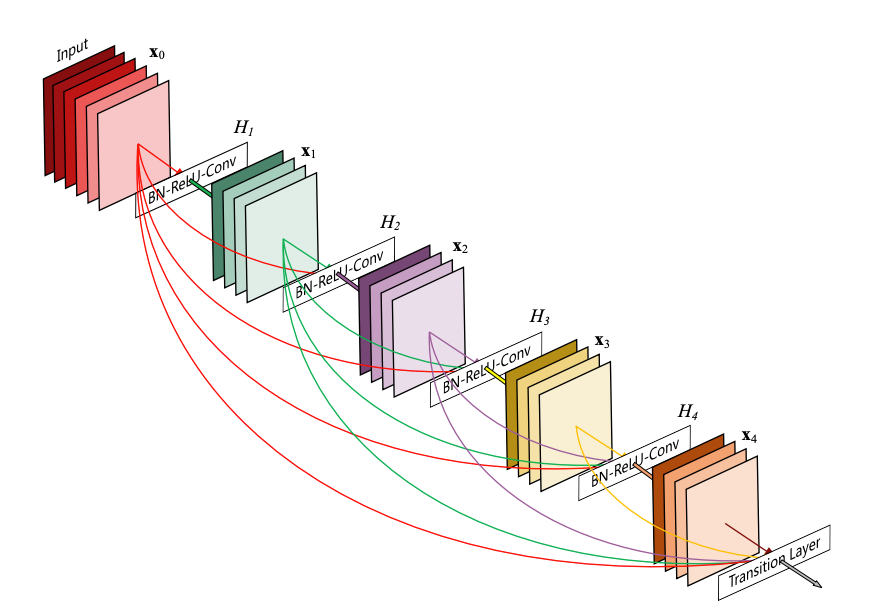

for more information about the DenseNet Architecture visit this website : https://keras.io/api/applications/densenet/


In [12]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [7]:
base_model.layers[:-17]

In [53]:
for layer in base_model.layers:
    layer.trainable = False

In [54]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [103]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


In [44]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The input shape Tensor("input_2:0", shape=(None, 224, 224, 3), dtype=float32)
The output shape Tensor("relu_1/Relu:0", shape=(None, 7, 7, 1024), dtype=float32)


In [107]:
#model = Sequential()
#base_model = DenseNet121(include_top=False, weights='imagenet')
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
x = Flatten()(base_model.output)

#x = GlobalAveragePooling2D()(x)

predictions = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
             optimizer= Adam(lr=0.001)#, decay=1e-5), 
              metrics=['accuracy'])

In [108]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [118]:
early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)
mcp_save = ModelCheckpoint('mdl_wts.h5', save_best_only=True, monitor='val_accuracy', mode='max')


In [122]:
class myCallback(Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy') > 0.93):
			print("\nReached 93% accuracy so cancelling training!")
			self.model.stop_training = True

callbacks = myCallback()

In [123]:
r = model.fit_generator(training_set,
          epochs=10,
          validation_data=test_set,
          class_weight=class_weight,
          callbacks=[callbacks],
          steps_per_epoch=len(training_set),
          validation_steps=25)


Epoch 1/10
327/327 [==============================] - 165s 505ms/step - loss: 0.0436 - accuracy: 0.9662 - val_loss: 0.0000e+00 - val_accuracy: 0.7600
Epoch 2/10
327/327 [==============================] - 172s 525ms/step - loss: 0.0535 - accuracy: 0.9623 - val_loss: 1.3113e-06 - val_accuracy: 0.9600

Reached 93% accuracy so cancelling training!


In [139]:
model.save('densenet_model.h5')

Text(0.5, 1.0, 'Accuracy Evolution')

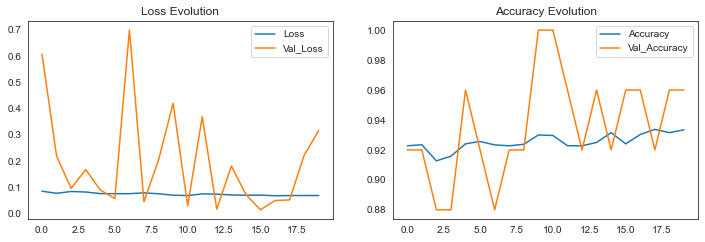

In [90]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [124]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 25s 40ms/step
Test Accuracy: 88.94%
104/164 [==================>...........] - ETA: 55s

KeyboardInterrupt: 

In [ ]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

In [ ]:
# Get predictions
preds = vgg_model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

In [ ]:
# Get the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'PNEUMONIA'], fontsize=16)
plt.yticks(range(2), ['Normal', 'PNEUMONIA'], fontsize=16)
plt.show()

# Evaluation

In [72]:
predicted_vals = model.predict(test, steps=len(test))

In [73]:
print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

NameError: name 'confusion_matrix' is not defined

# VGG16
Presented in 2014, VGG16 has a very simple and classical architecture, with blocks of 2 or 3 convolutional layers followed by a pooling layer, plus a final dense network composed of 2 hidden layers (of 4096 nodes each) and one output layer (of 1000 nodes). Only 3x3 filters are used.

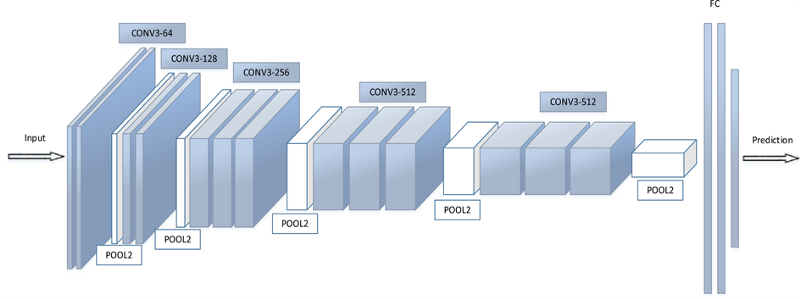

In [13]:

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                  brightness_range=[0.4,0.1],
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('../Dataset/Data/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 5232 images belonging to 2 classes.


In [15]:
test_set = test_datagen.flow_from_directory('../Dataset/Data/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [16]:
from keras.models import Sequential,Model
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16
from keras.layers import Input, Lambda, Dense, Flatten,Dropout



vgg16_base_model = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
# its important that we don't train existing weights
for layer in vgg16_base_model.layers:
    layer.trainable = False



In [17]:
x = Flatten()(vgg16_base_model.output)

In [18]:
prediction = Dense(2, activation='softmax')(x)

# create a model object
vgg_model = Model(inputs=vgg16_base_model.input, outputs=prediction)

In [26]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [30]:


    vgg16_model = tf.keras.Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

In [18]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-5)
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
vgg_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [74]:
early_stopping_monitor = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=True
)

In [75]:
r = vgg_model.fit_generator(training_set,
          epochs=10,
          validation_data=test_set,
          class_weight=class_weight,
          callbacks=[early_stopping_monitor],
          steps_per_epoch=len(training_set),
          validation_steps=25)



Epoch 1/10
327/327 [==============================] - 157s 481ms/step - loss: 0.0546 - accuracy: 0.9511 - precision: 0.9564 - recall: 0.9564 - val_loss: 2.6310e-04 - val_accuracy: 0.9200 - val_precision: 0.9511 - val_recall: 0.9511
Epoch 2/10
327/327 [==============================] - 162s 496ms/step - loss: 0.0551 - accuracy: 0.9450 - precision: 0.9477 - recall: 0.9477 - val_loss: 1.5259e-05 - val_accuracy: 0.9200 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 3/10
327/327 [==============================] - 166s 507ms/step - loss: 0.0532 - accuracy: 0.9488 - precision: 0.9473 - recall: 0.9473 - val_loss: 0.0052 - val_accuracy: 1.0000 - val_precision: 0.9482 - val_recall: 0.9482
Epoch 4/10
327/327 [==============================] - 168s 515ms/step - loss: 0.0556 - accuracy: 0.9453 - precision: 0.9477 - recall: 0.9477 - val_loss: 0.8006 - val_accuracy: 0.8800 - val_precision: 0.9475 - val_recall: 0.9475
Epoch 5/10
327/327 [==============================] - 168s 514ms/step - loss: 0.

In [76]:
vgg_model.save('vgg16_model92.h5')

C:\Users\mohammed\Anaconda3\envs\Tensor-gpu\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [27]:
# Define path to the data directory
data_dir = Path('../Dataset/Data/chest_xray/')

# Path to train directory (Fancy pathlib...no more os.path!!)
#train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [28]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [130]:
# Evaluation on test dataset
test_loss, test_score = vgg_model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 10s 17ms/step
Loss on test set:  0.4978888953352371
Accuracy on test set:  0.8637820482254028


In [131]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.83


In [93]:
print("precision",m)
print("recall",n)

NameError: name 'm' is not defined

In [19]:
 vgg_model.load_weights(r'C:\Users\mohammed\Downloads\vgg16_model92.h5')

In [3]:
# Allow memory growth for the GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 2 Logical GPUs


In [20]:
# Get predictions
preds = vgg_model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


In [21]:
# Lets plot the train and val curve
# Get the details form the history object
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

NameError: name 'r' is not defined

AUC Score: 0.8260683760683761


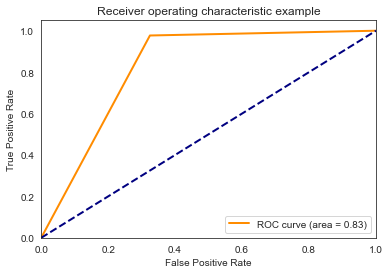

In [127]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( orig_test_labels , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

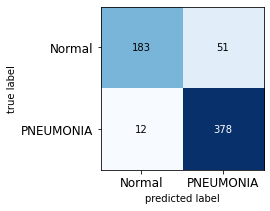

In [34]:
# Get the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(3,3), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'PNEUMONIA'], fontsize=12)
plt.yticks(range(2), ['Normal', 'PNEUMONIA'], fontsize=12)
plt.show()

In [129]:
evaluation =vgg_model.evaluate(test_set)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg_model.evaluate(training_set)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 23s 38ms/step
Test Accuracy: 86.38%
327/327 [==============================] - 168s 514ms/step
Train Accuracy: 79.43%


# ResNet

See the full explanation and schemes in the Research Paper on Deep Residual Learning (https://arxiv.org/pdf/1512.03385.pdf)

In [35]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')



C:\Users\mohammed\Anaconda3\envs\Tensor-gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [29]:
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [36]:
for layer in resnet_base_model.layers:
    layer.trainable = True


In [208]:
for i, layer in enumerate(resnet_base_model.layers):
    print(i,layer.name,"-",layer.trainable)

0 input_16 - True
1 conv1_pad - True
2 conv1 - True
3 bn_conv1 - True
4 activation_1039 - True
5 pool1_pad - True
6 max_pooling2d_43 - True
7 res2a_branch2a - True
8 bn2a_branch2a - True
9 activation_1040 - True
10 res2a_branch2b - True
11 bn2a_branch2b - True
12 activation_1041 - True
13 res2a_branch2c - True
14 res2a_branch1 - True
15 bn2a_branch2c - True
16 bn2a_branch1 - True
17 add_33 - True
18 activation_1042 - True
19 res2b_branch2a - True
20 bn2b_branch2a - True
21 activation_1043 - True
22 res2b_branch2b - True
23 bn2b_branch2b - True
24 activation_1044 - True
25 res2b_branch2c - True
26 bn2b_branch2c - True
27 add_34 - True
28 activation_1045 - True
29 res2c_branch2a - True
30 bn2c_branch2a - True
31 activation_1046 - True
32 res2c_branch2b - True
33 bn2c_branch2b - True
34 activation_1047 - True
35 res2c_branch2c - True
36 bn2c_branch2c - True
37 add_35 - True
38 activation_1048 - True
39 res3a_branch2a - True
40 bn3a_branch2a - True
41 activation_1049 - True
42 res3a_branch

In [37]:
x = Flatten()(resnet_base_model.output)

#x = GlobalAveragePooling2D()(x)

predictions = Dense(2, activation="softmax")(x)

resnet_model = Model(inputs=resnet_base_model.input, outputs=predictions)
opt = SGD(lr=0.001, momentum=0.9, decay=0.0001)
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [152]:
resnet_model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [19]:
from keras.callbacks import ReduceLROnPlateau
class myCallback(Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy') > 0.85):
			print("\nReached 93% accuracy so cancelling training!")
			self.model.stop_training = True

callbacks = myCallback()

In [21]:
r = resnet_model.fit_generator(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          callbacks=  [callbacks],
          verbose=1,
          steps_per_epoch=len(train),
          validation_steps=25)

Epoch 1/10
327/327 [==============================] - 278s 850ms/step - loss: 2.8101 - accuracy: 0.7796 - precision: 0.7595 - recall: 0.7595 - val_loss: 0.0000e+00 - val_accuracy: 0.5600 - val_precision: 0.7789 - val_recall: 0.7789
Epoch 2/10
327/327 [==============================] - 266s 813ms/step - loss: 1.0234 - accuracy: 0.8490 - precision: 0.7975 - recall: 0.7975 - val_loss: 5.4836e-06 - val_accuracy: 0.6000 - val_precision: 0.8134 - val_recall: 0.8134
Epoch 3/10
327/327 [==============================] - 267s 818ms/step - loss: 0.2666 - accuracy: 0.9060 - precision: 0.8291 - recall: 0.8291 - val_loss: 0.1136 - val_accuracy: 0.8000 - val_precision: 0.8440 - val_recall: 0.8440
Epoch 4/10
327/327 [==============================] - 268s 820ms/step - loss: 0.2009 - accuracy: 0.9253 - precision: 0.8540 - recall: 0.8540 - val_loss: 2.8866 - val_accuracy: 0.8400 - val_precision: 0.8642 - val_recall: 0.8642
Epoch 5/10
327/327 [==============================] - 268s 821ms/step - loss: 0.

In [14]:
r = resnet_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)


Epoch 1/10
100/100 [==============================] - 76s 759ms/step - loss: 0.1096 - accuracy: 0.9127 - precision: 0.8616 - recall: 0.8616 - val_loss: 2.3064e-04 - val_accuracy: 0.3600 - val_precision: 0.9103 - val_recall: 0.9103
Epoch 2/10
100/100 [==============================] - 77s 765ms/step - loss: 0.0444 - accuracy: 0.9650 - precision: 0.9263 - recall: 0.9263 - val_loss: 10.0000 - val_accuracy: 0.6000 - val_precision: 0.9360 - val_recall: 0.9360
Epoch 3/10
100/100 [==============================] - 79s 789ms/step - loss: 0.0344 - accuracy: 0.9683 - precision: 0.9419 - recall: 0.9419 - val_loss: 7.9871e-06 - val_accuracy: 0.4400 - val_precision: 0.9455 - val_recall: 0.9455
Epoch 4/10
100/100 [==============================] - 86s 855ms/step - loss: 0.0443 - accuracy: 0.9716 - precision: 0.9489 - recall: 0.9489 - val_loss: 14.0018 - val_accuracy: 0.5200 - val_precision: 0.9512 - val_recall: 0.9512
Epoch 5/10
100/100 [==============================] - 85s 849ms/step - loss: 0.032

In [37]:
resnet_model.save('resnet50_model80.h5')

In [38]:
resnet_model.load_weights(r'C:\Users\mohammed\Downloads\resnet50_model80.h5')

Text(0.5, 1.0, 'Accuracy Evolution')

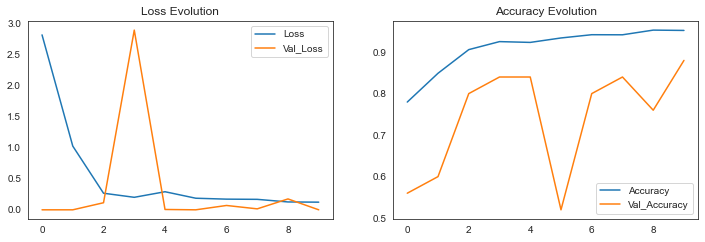

In [36]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [24]:
evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

#evaluation = resnet_model.evaluate(train)
#print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 20s 32ms/step
Test Accuracy: 82.37%


In [39]:
# Get predictions
preds = resnet_model.predict(test)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

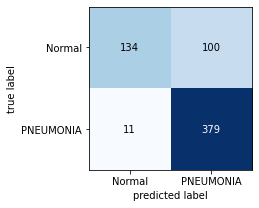

In [42]:
# Get the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(3,3), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'PNEUMONIA'], fontsize=10)
plt.yticks(range(2), ['Normal', 'PNEUMONIA'], fontsize=10)
plt.show()

AUC Score: 0.7803418803418802


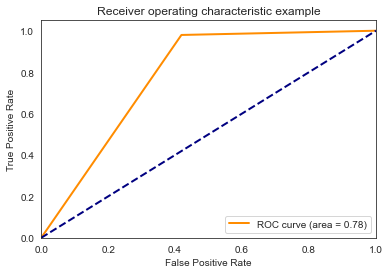

In [34]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( orig_test_labels , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [35]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.80


# InceptionNet
Also known as GoogleNet, this architecture presents sub-networks called inception modules, which allows fast training computing, complex patterns detection, and optimal use of parameters

for more information visit https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf



In [18]:
from keras.applications.mobilenet import MobileNet, preprocess_input
IMAGE_SIZE =[224,224]
#vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
mobilenet=MobileNet(
    input_shape=IMAGE_SIZE + [3],
    include_top=False,
    weights="imagenet"
)



In [19]:
for layer in mobilenet.layers[:]:
    layer.trainable = False
x = Flatten()(mobilenet.output)
#x=GlobalAveragePooling2D()(mobilenet.output)
prediction = Dense(2, activation='softmax')(x)

# create a model object
mobile_model = Model(inputs=mobilenet.input, outputs=prediction)


In [21]:
for i, layer in enumerate(mobile_model.layers):
    print(i,layer.name,"-",layer.trainable)

0 input_3 - False
1 conv1_pad - False
2 conv1 - False
3 conv1_bn - False
4 conv1_relu - False
5 conv_dw_1 - False
6 conv_dw_1_bn - False
7 conv_dw_1_relu - False
8 conv_pw_1 - False
9 conv_pw_1_bn - False
10 conv_pw_1_relu - False
11 conv_pad_2 - False
12 conv_dw_2 - False
13 conv_dw_2_bn - False
14 conv_dw_2_relu - False
15 conv_pw_2 - False
16 conv_pw_2_bn - False
17 conv_pw_2_relu - False
18 conv_dw_3 - False
19 conv_dw_3_bn - False
20 conv_dw_3_relu - False
21 conv_pw_3 - False
22 conv_pw_3_bn - False
23 conv_pw_3_relu - False
24 conv_pad_4 - False
25 conv_dw_4 - False
26 conv_dw_4_bn - False
27 conv_dw_4_relu - False
28 conv_pw_4 - False
29 conv_pw_4_bn - False
30 conv_pw_4_relu - False
31 conv_dw_5 - False
32 conv_dw_5_bn - False
33 conv_dw_5_relu - False
34 conv_pw_5 - False
35 conv_pw_5_bn - False
36 conv_pw_5_relu - False
37 conv_pad_6 - False
38 conv_dw_6 - False
39 conv_dw_6_bn - False
40 conv_dw_6_relu - False
41 conv_pw_6 - False
42 conv_pw_6_bn - False
43 conv_pw_6_relu -

In [29]:
mobile_model.compile(loss='binary_crossentropy',
              optimizer= Adam(lr=0.00001, decay=1e-2),
              metrics=['accuracy'])

In [30]:
from keras.callbacks import ReduceLROnPlateau
class myCallback(Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy') > 0.84):
			print("\nReached 93% accuracy so cancelling training!")
			self.model.stop_training = True

callbacks = myCallback()

In [31]:
r = mobile_model.fit_generator(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          callbacks= [callbacks],
          verbose=1,
          steps_per_epoch=len(train),
          validation_steps=25)

Epoch 1/10
164/164 [==============================] - 174s 1s/step - loss: 0.0168 - accuracy: 0.9872 - val_loss: 0.0000e+00 - val_accuracy: 0.4800
Epoch 2/10
164/164 [==============================] - 170s 1s/step - loss: 0.0147 - accuracy: 0.9878 - val_loss: 13.3968 - val_accuracy: 0.5200
Epoch 3/10
164/164 [==============================] - 168s 1s/step - loss: 0.0143 - accuracy: 0.9880 - val_loss: 0.0000e+00 - val_accuracy: 0.5200
Epoch 4/10
164/164 [==============================] - 168s 1s/step - loss: 0.0156 - accuracy: 0.9874 - val_loss: 0.0000e+00 - val_accuracy: 0.5200
Epoch 5/10
164/164 [==============================] - 171s 1s/step - loss: 0.0155 - accuracy: 0.9870 - val_loss: 0.0000e+00 - val_accuracy: 0.4800
Epoch 6/10
164/164 [==============================] - 170s 1s/step - loss: 0.0165 - accuracy: 0.9864 - val_loss: 0.0000e+00 - val_accuracy: 0.4400
Epoch 7/10
164/164 [==============================] - 171s 1s/step - loss: 0.0122 - accuracy: 0.9889 - val_loss: 9.3201 -

Text(0.5, 1.0, 'Accuracy Evolution')

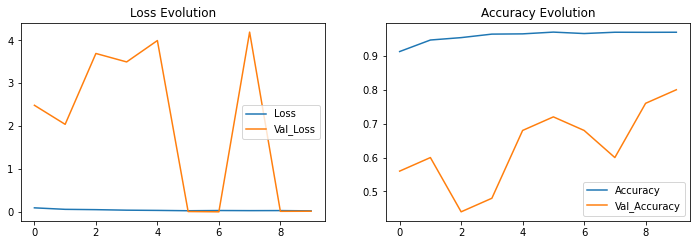

In [212]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [28]:
evaluation =mobile_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

#evaluation = mobile_model.evaluate(train)
#print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 64s 102ms/step
Test Accuracy: 62.66%


In [132]:
# Evaluation on test dataset
test_loss, test_score = mobile_model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 4s 7ms/step
Loss on test set:  3.7966202438808114
Accuracy on test set:  0.625


In [119]:
mobile_model.save('mobile_model80.h5')

In [13]:
from keras.applications import InceptionV3
from keras.layers import Input, Lambda, Dense, Flatten,Dropout
from keras.models import Model

inception_base_model = InceptionV3(input_shape=(224,224,3),include_top=False,weights='imagenet')

In [14]:
for layer in inception_base_model.layers:
    layer.trainable = True
x = Flatten()(inception_base_model.output)
#x=GlobalAveragePooling2D()(mobilenet.output)
prediction = Dense(2, activation='softmax')(x)

# create a model object
inception_model = Model(inputs=inception_base_model.input, outputs=prediction)

In [15]:
from keras.optimizers import Adam,SGD

In [16]:
opt = SGD(lr=0.0001, momentum=0.9, decay=0.0001)
inception_model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

In [17]:
from keras.callbacks import ReduceLROnPlateau
class myCallback(Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy') > 0.95):
			print("\nReached 93% accuracy so cancelling training!")
			self.model.stop_training = True

callbacks = myCallback()

In [18]:
r =inception_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          callbacks= [callbacks],
          verbose=1,
          steps_per_epoch=len(train),
          validation_steps=25)

Epoch 1/10
327/327 [==============================] - 194s 593ms/step - loss: 0.2534 - accuracy: 0.8962 - val_loss: 0.0475 - val_accuracy: 0.8800
Epoch 2/10
327/327 [==============================] - 191s 583ms/step - loss: 0.1430 - accuracy: 0.9461 - val_loss: 4.5299e-06 - val_accuracy: 0.8800
Epoch 3/10
327/327 [==============================] - 221s 674ms/step - loss: 0.1164 - accuracy: 0.9570 - val_loss: 1.5404 - val_accuracy: 0.7600
Epoch 4/10
327/327 [==============================] - 222s 680ms/step - loss: 0.0937 - accuracy: 0.9656 - val_loss: 1.1921e-07 - val_accuracy: 0.9200
Epoch 5/10
327/327 [==============================] - 224s 686ms/step - loss: 0.0795 - accuracy: 0.9713 - val_loss: 1.3649e-04 - val_accuracy: 0.9600

Reached 93% accuracy so cancelling training!


Text(0.5, 1.0, 'Accuracy Evolution')

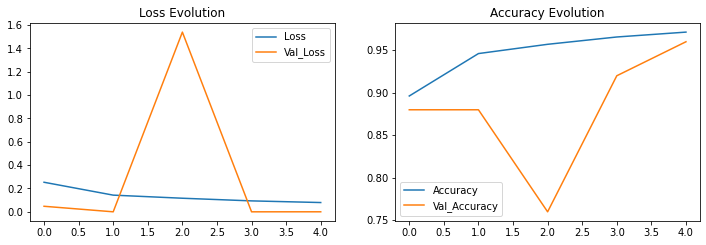

In [33]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [24]:
inception_model.save('inception_model86.h5')

In [19]:
evaluation =inception_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 24s 39ms/step
Test Accuracy: 87.66%


In [26]:
evaluation =inception_model.evaluate(test_data,test_labels)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 5s 8ms/step
Test Accuracy: 72.44%


In [42]:
last_layer =inception_base_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [43]:
x =Flatten()(last_output)
prediction = Dense(2, activation='softmax')(x)
inception_model = Model(inputs=inception_base_model.input, outputs=prediction)

In [20]:
# Get predictions
preds =inception_model.predict(test_data)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


In [27]:
# Get predictions
preds =inception_model.predict(test)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test.classes, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

()
(624,)


<Figure size 432x288 with 0 Axes>

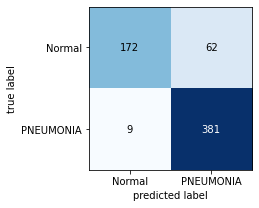

In [34]:
# Get the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm  = confusion_matrix(test.classes, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(3,3), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'PNEUMONIA'], fontsize=10)
plt.yticks(range(2), ['Normal', 'PNEUMONIA'], fontsize=10)
plt.show()

In [30]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.86


AUC Score: 0.855982905982906


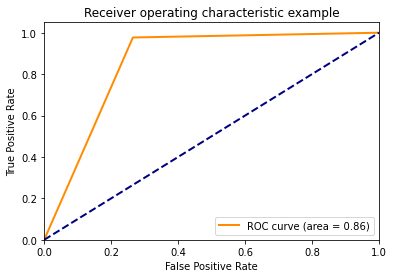

In [32]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( test.classes , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [79]:
for i, layer in enumerate(inception_model.layers):
    print(i,layer.name,"-",layer.trainable)

0 input_7 - False
1 conv2d_283 - False
2 batch_normalization_283 - False
3 activation_283 - False
4 conv2d_284 - False
5 batch_normalization_284 - False
6 activation_284 - False
7 conv2d_285 - False
8 batch_normalization_285 - False
9 activation_285 - False
10 max_pooling2d_13 - False
11 conv2d_286 - False
12 batch_normalization_286 - False
13 activation_286 - False
14 conv2d_287 - False
15 batch_normalization_287 - False
16 activation_287 - False
17 max_pooling2d_14 - False
18 conv2d_291 - False
19 batch_normalization_291 - False
20 activation_291 - False
21 conv2d_289 - False
22 conv2d_292 - False
23 batch_normalization_289 - False
24 batch_normalization_292 - False
25 activation_289 - False
26 activation_292 - False
27 average_pooling2d_28 - False
28 conv2d_288 - False
29 conv2d_290 - False
30 conv2d_293 - False
31 conv2d_294 - False
32 batch_normalization_288 - False
33 batch_normalization_290 - False
34 batch_normalization_293 - False
35 batch_normalization_294 - False
36 activati